# Solving the Cournot Oligopoly Model by Collocation
**DEMAPP09 Cournot Oligopolist Problem**
<br>

This example is taken from section 6.8.1, page(s) 159-162 of:

Miranda, M. J., & Fackler, P. L. (2002). Applied computational economics and finance (P. L. Fackler, ed.). Cambridge, Mass. : MIT Press.

<br>
To illustrate the implementation of the collocation method for implicit function problems, consider the case of a Cournot oligopoly. In the standard microeconomic model of the firm, the firm maximizes its profits by matching marginal revenue to marginal cost (MC). An oligopolistic firm, recognizing that its actions affect the price, knows that its marginal revenue is $p + q \frac{dp}{dq}$, where $p$ is the price, $q$ the quantity produced, and $\frac{dp}{dq}$ is the marginal impact of the product on the market price. Cournot's assumption is that the company acts as if none of its production changes would provoke a reaction from its competitors. This implies that:
\begin{equation}
    \frac{dp}{dq} = \frac{1}{D'(p)} \tag{1}
\end{equation}

where $D(p)$ is the market demand curve.

<br>
Suppose we want to derive the firm's effective supply function, which specifies the amount $q = S(p)$ that it will supply at each price. The effective supply function of the firm is characterized by the functional equation
\begin{equation}
    p + \frac{S(p)}{D'(p)} - MC(S(p)) = 0 \tag{2}
\end{equation}

for every price $p>0$. In simple cases, this function can be found explicitly. However, in more complicated cases, there is no explicit solution. Suppose for example that demand and marginal cost are given by
\begin{equation*}
D(p) = p^{-\eta}  \qquad\qquad CM(q) = \alpha\sqrt{q} + q^2 
\end{equation*}

so that the functional equation to be solved for $S(p)$ is
\begin{equation} \label{eq:funcional}
\left[p - \frac{S(p)p^{\eta+1}}{\eta}\right] - \left[\alpha\sqrt{S(p)} + S(p)^2\right] = 0 \tag{3}
\end{equation}

## The collocation method
In equation (3), the unknown is the supply *function* $S(p)$, which makes (3) an infinite-dimension equation. Instead of solving the equation directly, we will approximate its solution using $n$ Chebyshev polynomials $\phi_i(x)$, which are defined recursively for $x \in [0,1]$ as:
\begin{align*}
\phi_0(x) & = 1 \\
\phi_1(x) & = x \\
\phi_{k + 1}(p_i) & = 2x \phi_k(x) - \phi_{k-1}(x), \qquad \text{for} \; k = 1,2, \dots
\end{align*}

<br>
In addition, instead of requiring that both sides of the equation be exactly equal over the entire domain of $p \in \Re^+$, we will choose $n$ Chebyshev nodes $p_i$ in the interval $[a, b]$:
\begin{equation} \label{eq:chebynodes}
p_i = \frac{a + b}{2} + \frac{ba}{2}\ cos\left(\frac{n-i + 0.5}{n}\pi\right), \qquad\text{for } i = 1,2, \dots, n  \tag{4}
\end{equation}

<br>
Thus, the supply is approximated by
\begin{equation*}
S(p_i) = \sum_{k = 0}^{n-1} c_{k}\phi_k(p_i)
\end{equation*}

Substituting this last expression in (3) for each of the placement nodes (Chebyshev in this case) results in a non-linear system of $ n $ equations (one for each node) in $ n $ unknowns $ c_k $ (one for each polynomial of Cheybshev), which in principle can be solved by Newton's method, as in the last example. Thus, in practice, the system to be solved is

\begin{equation} \label{eq:collocation}
\left[p_i - \frac{\left(\sum_{k=0}^{n-1}c_{k}\phi_k(p_i)\right)p_i^{\eta+1}}{\eta}\right] - \left[\alpha\sqrt{\sum_{k=0}^{n-1}c_{k}\phi_k(p_i)} + \left(\sum_{k=0}^{n-1}c_{k}\phi_k(p_i)\right)^2\right] = 0  \tag{5}
\end{equation}

for $i=1,2,\dots, n$ and for $k=1,2,\dots,n$.

## Solving the model withPython
To solve this model we start a new Python session:

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from compecon import BasisChebyshev, NLP, nodeunif
from compecon.demos import demo


and set the $\alpha$ and $\eta$ parameters

In [3]:
alpha= 1.0;
eta= 1.5;

For convenience, we define a `lambda` function to represent the demand. **Note: A lambda function is a small anonymous function in Python that can take any number of arguments, but can have only one expression. If you are curious to learn more Google "Lambda Functions in Python".**

In [4]:
D = lambda p: p** (-eta)

We will approximate the solution for prices in the $p\in [a, b]$ interval, using 25 collocation nodes. The `compecon` library provides the `BasisChebyshev` class to make computations with Chebyshev bases:

In [5]:
n= 25;
a= 0.1;
b= 3.0
S= BasisChebyshev(n, a, b, labels= ['price'], l=['supply'])

Let's assume that our first guess is $S(p)=1$. To that end, we set the value of `S` to one in each of the nodes

In [6]:
p= S.nodes
S.y= np.ones_like(p)

It is important to highlight that in this problem the unknowns are the $c_k$ coefficients from the Chebyshev basis; however, an object of  `BasisChebyshev` class automatically adjusts those coefficients so they are consistent with the values we set for the function at the nodes (here indicated by the `.y` property).

<br>
We are now ready to define the objective function, which we will call `resid`. This function takes as its argument a vector with the 25 Chebyshev basis coefficients and returns the left-hand side of the 25 equations defined by (5). 

In [7]:
def resid(c):
    S.c= c  # update interpolation coefficients
    q= S(p) # compute quantity supplied at price nodes
    return p- q* (p** (eta+ 1)/ eta)- alpha* np.sqrt(q)- q** 2

Note that the `resid` function takes a single argument (the coefficients for the Chebyshev basis). All other parameters (`Q, p, eta, alpha` must be declared in the main script, where Python will find their values.

<br>

To use Newton's method, it is necessary to compute the Jacobian matrix of the function whose roots we are looking for. In certain occasions, like in the problem we are dealing with, coding the computation of this Jacobian matrix correctly can be quite cumbersome. The `NLP` class provides, besides the Newton's method (which we used in the last example), the [Broyden's Method](http://www.matthewaaronlooney.com/Optim_Class_Fall2019/Broydens_Method.html), whose main appeal is that it does not require the coding of the Jacobian matrix (the method itself will approximate it). To learn more about Broyden's Method, click on the hyperlink above and see Quasi-Newton Methods in section 3.4, page(s) 39-42 of the text.

In [8]:
cournot = NLP(resid)
S.c = cournot.broyden(S.c, tol=1e-12)

After 20 iterations, Broyden's method converges to the desired solution. We can visualize this in Figure 3, which shows the value of the function on 501 different points within the approximation interval. Notice that the residual plot crosses the horizontal axis 25 times; this occurs precisely at the collocation nodes (represented by red dots). This figure also shows the precision of the approximation: outside nodes, the function is within  $\approx 1\times10^{-17}$ units from zero.

<br>
One of the advantages of working with the `BasisChebyshev` class is that, once the collocation coefficients have been found, we can evaluate the supply function by calling the `S` object as if it were a Python function. Thus, for example, to find out the quantity supplied by the firm when the price is 1.2, we simply evaluate `print(S(1.2))`, which returns `0.3950`. We use this feature next to compute the effective supply curve when there are 5 identical firms in the market; the result is shown in Figure 2.

##### Figure 2 Supply and demand when there are 5 firms

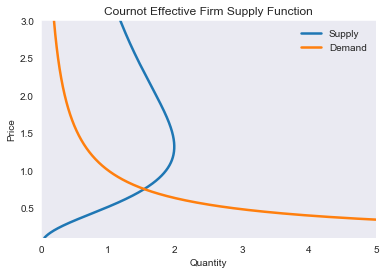

In [9]:
nFirms= 5;
pplot = nodeunif(501, a, b)
demo.figure('Cournot Effective Firm Supply Function', 
            'Quantity', 'Price', [0, nFirms], [a, b])
plt.plot(nFirms* S(pplot), pplot, D(pplot), pplot)
plt.legend(('Supply','Demand'))
plt.show();

##### Figure 3: Approximation residuals for equation (5)

This block generates Figure 3.

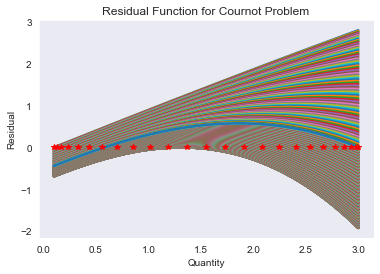

In [10]:
p= pplot 
demo.figure('Residual Function for Cournot Problem',
            'Quantity', 'Residual')
plt.hlines(0, a, b, 'k', '--', lw= 2)
plt.plot(pplot, resid(S.c))
plt.plot(S.nodes,np.zeros_like(S.nodes),'r*');
plt.show();

##### Figure 4: Change in the effective supply as the number of firms increases
We now plot the effective supply for a varying number of firms; the result is shown in Figure 4.

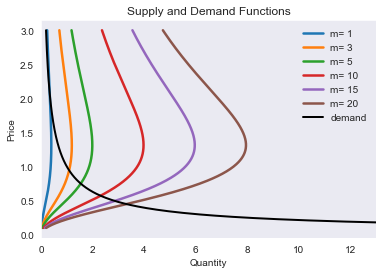

In [11]:
m= np.array([1, 3, 5, 10, 15, 20])
demo.figure('Supply and Demand Functions', 'Quantity', 'Price', [0, 13])
plt.plot(np.outer(S(pplot), m), pplot)
plt.plot(D(pplot), pplot, linewidth= 2, color='black')
plt.legend(['m= 1', 'm= 3', 'm= 5', 'm= 10', 'm= 15', 'm= 20', 'demand']);
plt.show();

In Figure 4 notice how the equilibrium price and quantity change as the number of firms increases. 

##### Figure 5: Equilibrium price as a function of the number of firms

The last figure in this example (Figure 5), shows the equilibrium price as a function of the number of firms.

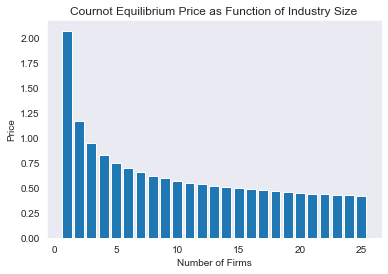

In [12]:
pp= (b+ a)/ 2
dp= (b- a)/ 2
m = np.arange(1, 26)
for i in range(50):
    dp/= 2
    pp= pp- np.sign(S(pp)* m- D(pp))* dp

demo.figure('Cournot Equilibrium Price as Function of Industry Size', 
            'Number of Firms', 'Price')
plt.bar(m, pp);
plt.show();

# References

Miranda, M. J., & Fackler, P. L. (2002). Applied computational economics and finance (P. L. Fackler, ed.). Cambridge, Mass. : MIT Press.

Miranda, M. J., & Fackler, P. L., Romero-Aguilar, R (2002, 2016). CompEcon Toolbox (MATLAB).

